In [633]:
import tensorflow.keras as keras
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
from tqdm import tqdm
from scipy.stats import multivariate_normal
from sklearn.model_selection import train_test_split

(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)
y_train, y_test = y_train[:, 0], y_test[:, 0]

In [634]:
'''
from skimage.transform import resize
(X_ood, _), _ = keras.datasets.mnist.load_data()

X_ood = X_ood[np.random.choice(range(len(X_ood)), int(len(X_ood) / 20))]

_X_ood = np.zeros((len(X_ood), 28, 28, 3))

for k in range(3):
    _X_ood[:, :, :, k] = X_ood

X_ood = np.array([resize(_X_ood[i], (32, 32)) for i in tqdm(range(len(X_ood)))])
'''
indices_of_ood_subclasses = np.where(y_train >= 2)[0]
indices_of_ood_subclasses = np.random.choice(indices_of_ood_subclasses, int(len(X_train) / 20))
X_ood = X_train[indices_of_ood_subclasses]

In [577]:

indices_of_subclasses = np.where(y_train < 2)[0]
X_train, y_train = X_train[indices_of_subclasses], y_train[indices_of_subclasses]

indices_of_subclasses = np.where(y_val < 2)[0]
X_val, y_val = X_val[indices_of_subclasses], y_val[indices_of_subclasses]

#random_indices = np.random.choice(range(len(y_test)), 1000, replace = False)
#X_train, y_train = X_train[random_indices], y_train[random_indices]
#random_indices = np.random.choice(range(len(y_test)), 500, replace = False)
#X_test, y_test = X_test[random_indices], y_test[random_indices]
indices_of_subclasses = np.where(y_test < 2)[0]
X_test, y_test = X_test[indices_of_subclasses], y_test[indices_of_subclasses]

In [578]:
#load and train model 
inp = keras.layers.Input(np.shape(X_train)[1:])

x = keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(inp)
x = keras.layers.MaxPooling2D()(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(x)
x = keras.layers.MaxPooling2D()(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Flatten()(x)


x = keras.layers.Dense(units=1024, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(units=512, activation='relu')(x)
enc = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.2)(x)
cls_logits = keras.layers.Dense(units=len(np.unique(y_train)), activation = 'linear')(enc)
cls_out = keras.layers.Activation('softmax', name = 'cls_out')(cls_logits)

network = keras.models.Model(inputs = inp, outputs = cls_out)
encoder = keras.models.Model(inputs = inp, outputs = enc)

import tensorflow as tf
x = keras.layers.Dense(100, activation = 'relu')(enc)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(100, activation = 'relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(100, activation = 'relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.2)(x)
pre_temperature = keras.layers.Dense(units = 1, activation = 'linear')(x)
#temperature = keras.layers.Lambda(lambda v : keras.activations.sigmoid(v) * 10)(pre_temperature)
#custom loss. We want the temperature to be unbounded on the positive side (and therefore when the pretemperature is greater than 0, it's unbounded; 
#but we also need to make sure the temperature is never negative - so we don't get infinite logits. So we do an exponentially decaying activation on the negative side)
temperature = keras.layers.Activation(lambda v : tf.where(v < 0, keras.activations.exponential(v), 1 + keras.activations.linear(v)))(pre_temperature)
ood_cls_logits = keras.layers.Lambda(lambda inputs: inputs[0] / inputs[1])([cls_logits, temperature])
ood_cls_out = keras.layers.Activation('softmax')(ood_cls_logits)

temperature_model = keras.models.Model(inputs = enc, outputs = temperature)
ood_network = keras.models.Model(inputs = enc, outputs = ood_cls_out)
ood_logits_network = keras.models.Model(inputs = enc, outputs = ood_cls_logits)
logits_network = keras.models.Model(inputs = enc, outputs = cls_logits)
encoding_network = keras.models.Model(inputs = enc, outputs = cls_out)
ood_network.compile(loss='categorical_crossentropy',
          optimizer=keras.optimizers.Adam(learning_rate=3e-4))

network.compile(loss='categorical_crossentropy',
          optimizer=keras.optimizers.Adam(learning_rate=3e-3),
          metrics = ['acc'])

network.fit(X_train, keras.utils.to_categorical(y_train), 
    epochs = 15,
    verbose = 1,
    validation_split = .1)

Epoch 1/15
253/253 [==============================] - 3s 7ms/step - loss: 0.4584 - acc: 0.8281 - val_loss: 0.8910 - val_acc: 0.7019
Epoch 2/15
253/253 [==============================] - 1s 6ms/step - loss: 0.2701 - acc: 0.8938 - val_loss: 0.3821 - val_acc: 0.8487
Epoch 3/15
253/253 [==============================] - 1s 6ms/step - loss: 0.2213 - acc: 0.9112 - val_loss: 0.2691 - val_acc: 0.8966
Epoch 4/15
253/253 [==============================] - 1s 6ms/step - loss: 0.1869 - acc: 0.9258 - val_loss: 0.1886 - val_acc: 0.9333
Epoch 5/15
253/253 [==============================] - 1s 6ms/step - loss: 0.1507 - acc: 0.9411 - val_loss: 0.2221 - val_acc: 0.9199
Epoch 6/15
253/253 [==============================] - 1s 6ms/step - loss: 0.1464 - acc: 0.9446 - val_loss: 0.1911 - val_acc: 0.9288
Epoch 7/15
253/253 [==============================] - 2s 6ms/step - loss: 0.1224 - acc: 0.9510 - val_loss: 0.3446 - val_acc: 0.8888
Epoch 8/15
253/253 [==============================] - 2s 6ms/step - loss: 0.

In [579]:
encoding_X_train = encoder.predict(X_train).reshape(X_train.shape[0], -1)
encoding_X_val = encoder.predict(X_val).reshape(X_val.shape[0], -1)
encoding_X_test = encoder.predict(X_test).reshape(X_test.shape[0], -1)

In [635]:
encoding_X_ood = encoder.predict(X_ood).reshape(X_ood.shape[0], -1)

In [581]:
from scipy.spatial.distance import cosine
class_means, class_lower_percentile, class_upper_percentile, class_mean_percentile = [], [], [], []
for c in tqdm(range(len(np.unique(y_train)))):
    examples_of_class = np.where(y_val == c)[0]
    class_means.append(np.mean(encoding_X_val[examples_of_class], axis = 0))
    class_lower_percentile.append(np.percentile([cosine(encoding_X_val[i], class_means[c]) for i in examples_of_class], 60))
    class_upper_percentile.append(np.percentile([cosine(encoding_X_val[i], class_means[c]) for i in examples_of_class], 100))
    class_mean_percentile.append(np.percentile([cosine(encoding_X_val[i], class_means[c]) for i in examples_of_class], 50))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.11it/s]


  0%|                                                                                                                                                                                                                                                     | 0/2 [00:00<?, ?it/s]

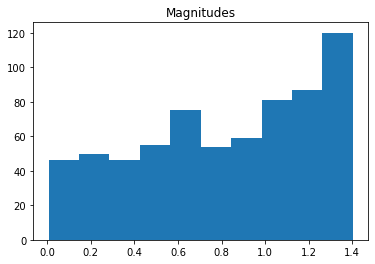

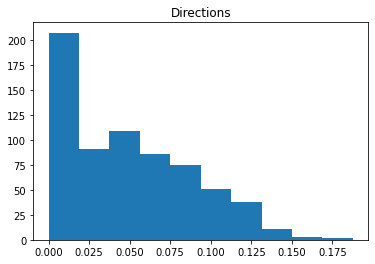

 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                      | 1/2 [00:00<00:00,  2.37it/s]

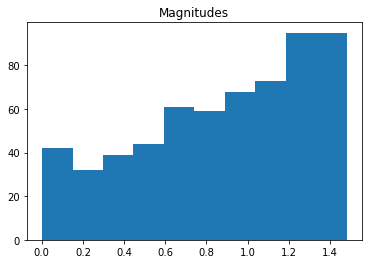

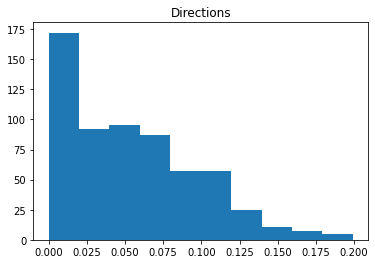

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.41it/s]


In [582]:
from scipy.stats import multivariate_normal as mv
import matplotlib.pyplot as plt
vos_samples = []
close_classes_per_sample = []
for c in tqdm(range(len(np.unique(y_train)))):
    examples_of_class = np.where(y_val == c)[0]
    vos_samples_of_class = mv.rvs(mean = 0, cov = 1, size = (int(len(examples_of_class)) * 2, np.shape(encoding_X_val)[1]))
    vos_samples_of_class = vos_samples_of_class / np.linalg.norm(vos_samples_of_class, axis =1)[:, np.newaxis]
    magnitudes = class_upper_percentile[c] - class_upper_percentile[c] * np.random.exponential(scale = 1, size = len(vos_samples_of_class))#np.random.uniform(class_lower_percentile[c], class_upper_percentile[c], size = len(vos_samples_of_class))
    positive_magnitudes = np.where(magnitudes > 0)[0]
    plt.hist(magnitudes[positive_magnitudes])
    plt.title("Magnitudes")
    plt.show()
    vos_samples_of_class = class_means[c] + vos_samples_of_class[positive_magnitudes] * magnitudes[positive_magnitudes, np.newaxis]
    directions = []
    for sample in vos_samples_of_class:
        is_distant = True
        direction_from_generating_class = sample - class_means[c]
        max_direction_similarity = 0
        close_classes = [c]
        for j in range(len(np.unique(y_val))):
            if j != c:
                class_upper_percentile[j]
                class_means[j]
                direction_from_other_class_center = sample - class_means[j]
                direction_similarity = 1 - cosine(direction_from_generating_class, direction_from_other_class_center)
                if direction_similarity > max_direction_similarity:
                    max_direction_similarity = direction_similarity
                if direction_similarity > 0.1:
                    close_classes.append(j)
        directions.append(max_direction_similarity)
        close_classes_per_sample.append(close_classes)
    plt.hist(directions)
    plt.title("Directions")
    plt.show()
    vos_samples.extend(vos_samples_of_class)

In [583]:
vos_labels = np.zeros((len(close_classes_per_sample), len(np.unique(y_val))))
for i in range(len(close_classes_per_sample)):
    if len(close_classes_per_sample[i]) == 1:
        vos_labels[i] = np.ones((len(np.unique(y_train)))) / len(np.unique(y_val))
    else:
        label = np.zeros((len(np.unique(y_val))))
        for j in close_classes_per_sample[i]:
            label[j] = 1
        label /= np.sum(label)
        vos_labels[i] = label

In [584]:
#vos_labels = vos_labels[np.where([len(v) == 1 for v in close_classes_per_sample])[0]]
#vos_samples = np.array(vos_samples)[np.where([len(v) == 1 for v in close_classes_per_sample])[0]]

In [585]:
ood_X_val = np.concatenate([encoding_X_val, vos_samples], axis = 0)
ood_y_val = np.concatenate([keras.utils.to_categorical(y_val), vos_labels])

random_order = np.arange(len(ood_X_val))
np.random.shuffle(random_order)
ood_X_val, ood_y_val = ood_X_val[random_order], ood_y_val[random_order]

In [586]:
for layer in network.layers:
    layer.trainable = False
    
ood_network.fit(ood_X_val, ood_y_val, 
    epochs = 100,
    verbose = 1,
    validation_split = .1,
    callbacks = keras.callbacks.EarlyStopping(patience = 10))

Epoch 1/100
65/65 [==============================] - 2s 8ms/step - loss: 1.7027 - val_loss: 1.1829
Epoch 2/100
65/65 [==============================] - 0s 5ms/step - loss: 110.6898 - val_loss: 0.9963
Epoch 3/100
65/65 [==============================] - 0s 5ms/step - loss: 3.0406 - val_loss: 0.6634
Epoch 4/100
65/65 [==============================] - 0s 5ms/step - loss: 0.9648 - val_loss: 0.5799
Epoch 5/100
65/65 [==============================] - 0s 5ms/step - loss: 0.8524 - val_loss: 0.5547
Epoch 6/100
65/65 [==============================] - 0s 5ms/step - loss: 0.7531 - val_loss: 0.5409
Epoch 7/100
65/65 [==============================] - 0s 5ms/step - loss: 0.8990 - val_loss: 0.5343
Epoch 8/100
65/65 [==============================] - 0s 5ms/step - loss: 0.9677 - val_loss: 0.5316
Epoch 9/100
65/65 [==============================] - 0s 5ms/step - loss: 1.0906 - val_loss: 0.5354
Epoch 10/100
65/65 [==============================] - 0s 5ms/step - loss: 0.7549 - val_loss: 0.5282
Epoch 1

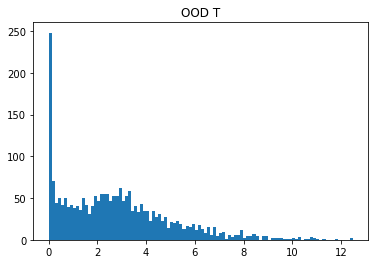

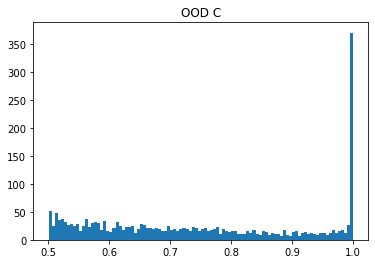

OOD T:  2.7660725
OOD C:  0.75018495


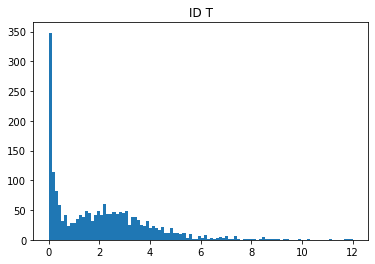

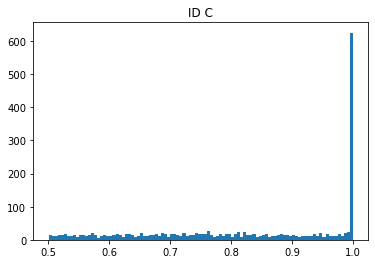

ID T:  2.065378
ID C:  0.82943946
AUC T:  0.5942757777777778
AUC C:  0.6344008888888889


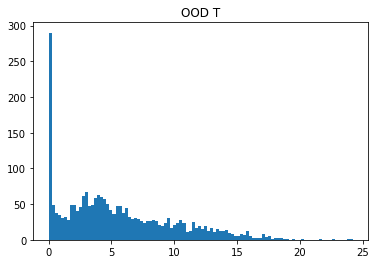

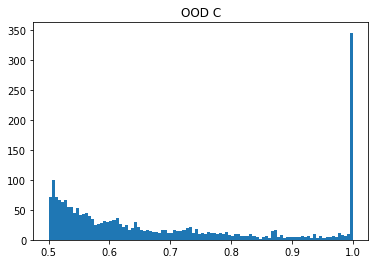

OOD T:  5.4892344
OOD C:  0.69140476


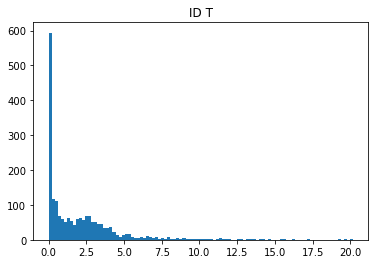

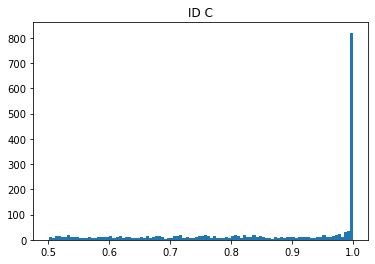

ID T:  1.9861932
ID C:  0.8594644
AUC T:  0.7526628888888889
AUC C:  0.7481042222222223


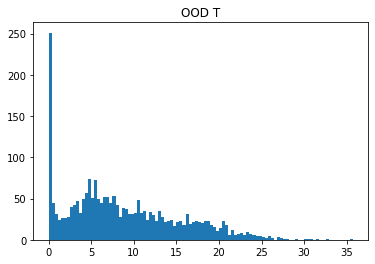

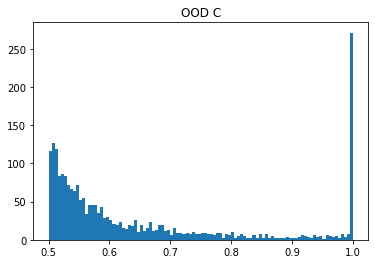

OOD T:  8.729547
OOD C:  0.65244573


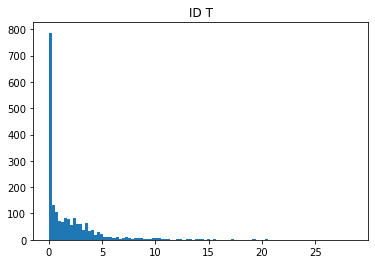

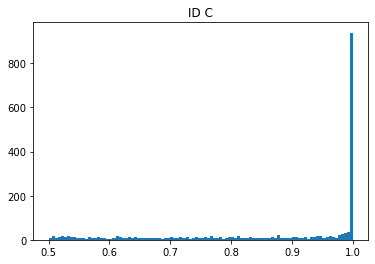

ID T:  1.9940926
ID C:  0.8758566
AUC T:  0.8294448888888889
AUC C:  0.8116254444444444


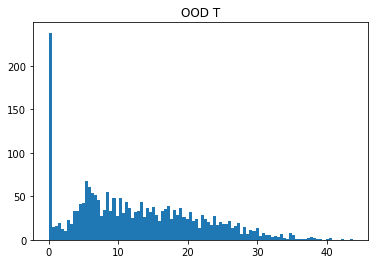

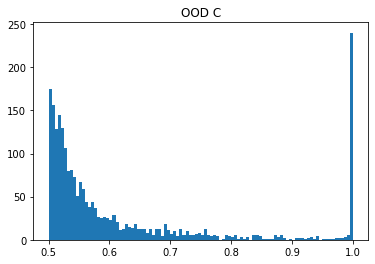

OOD T:  12.65698
OOD C:  0.62181336


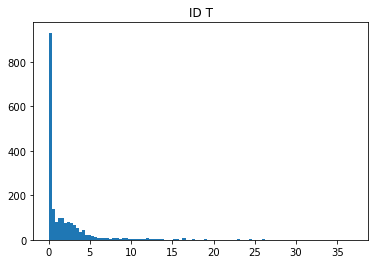

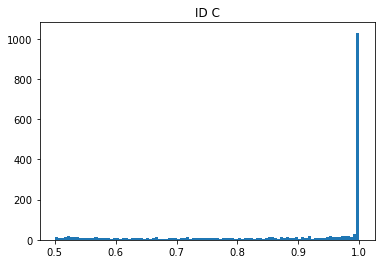

ID T:  2.0552938
ID C:  0.8859075
AUC T:  0.8713537777777778
AUC C:  0.8510939828717606


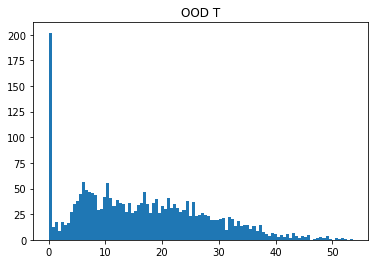

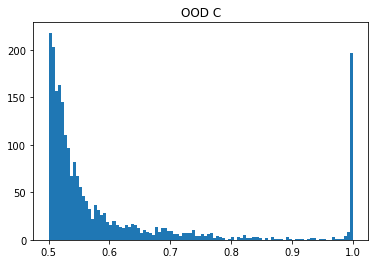

OOD T:  16.525091
OOD C:  0.603183


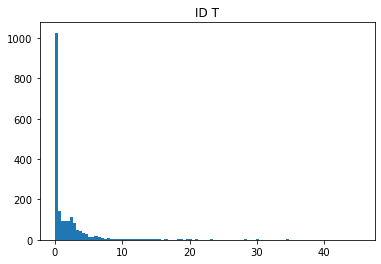

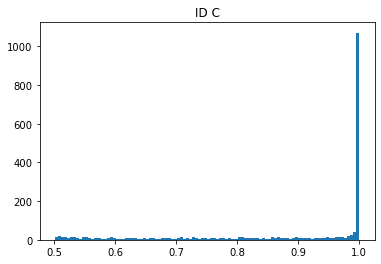

ID T:  2.1447983
ID C:  0.8923383
AUC T:  0.894352
AUC C:  0.8755245114461195


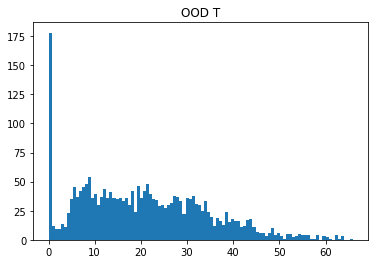

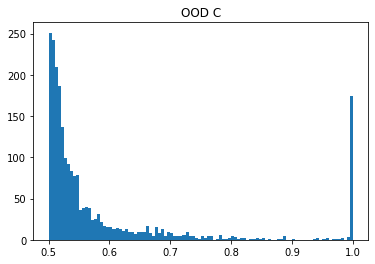

OOD T:  20.585579
OOD C:  0.5887484


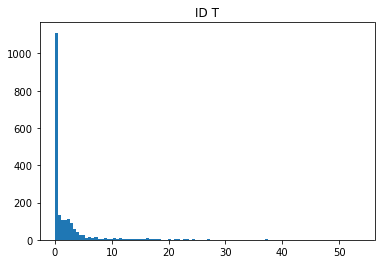

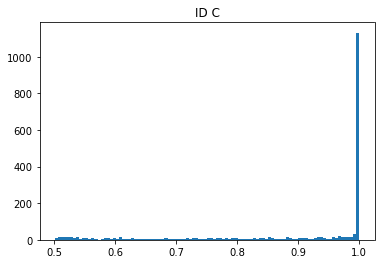

ID T:  2.2530372
ID C:  0.898913
AUC T:  0.9102211111111111
AUC C:  0.8929445003916303


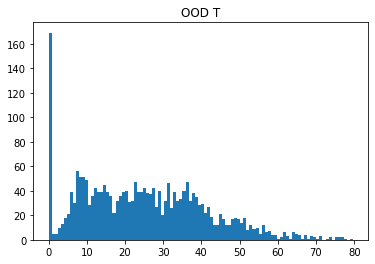

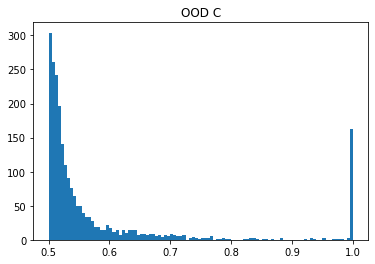

OOD T:  24.812752
OOD C:  0.57896084


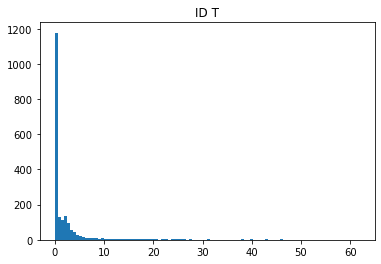

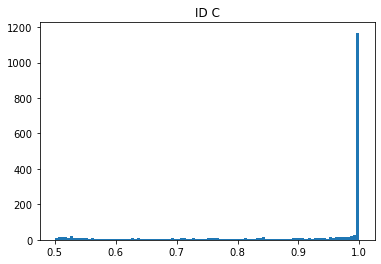

ID T:  2.3731363
ID C:  0.90250325
AUC T:  0.9199511111111112
AUC C:  0.9031587462082912


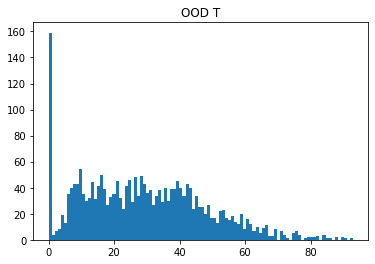

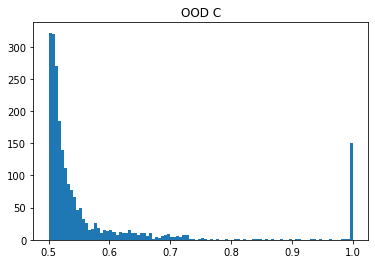

OOD T:  29.120398
OOD C:  0.5722831


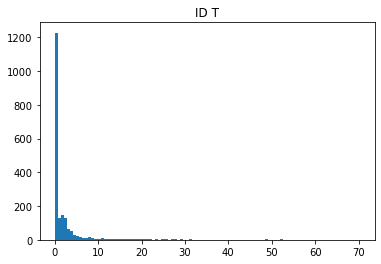

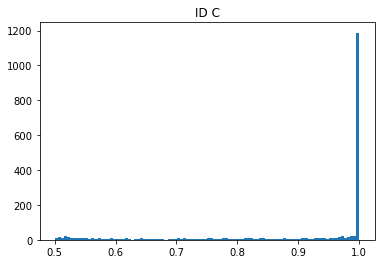

ID T:  2.5015724
ID C:  0.9053499
AUC T:  0.9267693333333333
AUC C:  0.9110558381372218


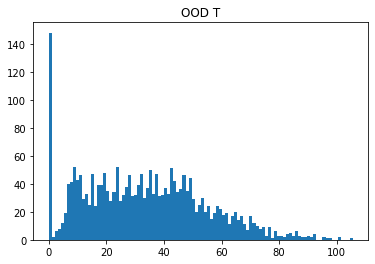

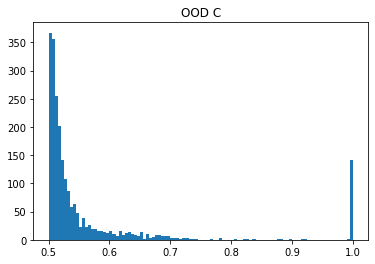

OOD T:  33.370514
OOD C:  0.5657157


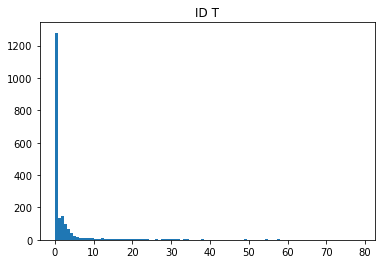

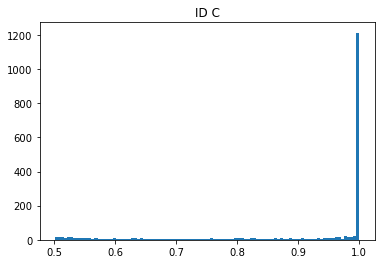

ID T:  2.6364877
ID C:  0.90833074
AUC T:  0.9326691143747219
AUC C:  0.9179517247718612


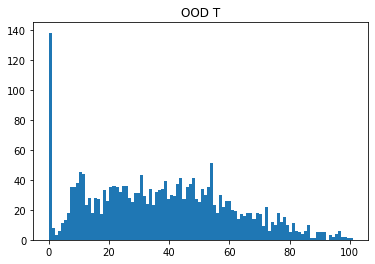

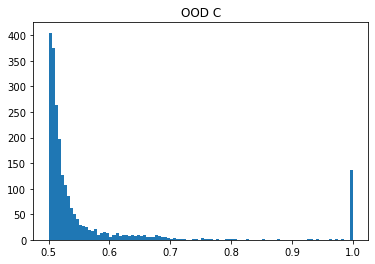

OOD T:  37.345325
OOD C:  0.5624003


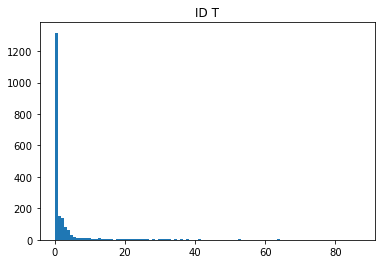

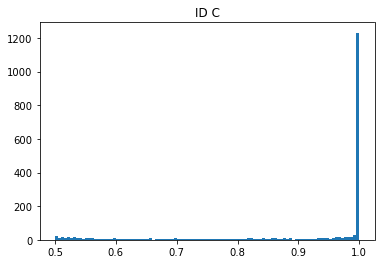

ID T:  2.774694
ID C:  0.9107019
AUC T:  0.9362548184670553
AUC C:  0.9210166764357712


In [639]:
from sklearn.metrics import roc_auc_score
from copy import deepcopy
import tensorflow as tf
encoding_X_ood_grad = deepcopy(encoding_X_ood)
encoding_X_test_grad = deepcopy(encoding_X_test)
auc_ts = []
auc_cs = []
for _ in range(10):
    tensor = tf.convert_to_tensor(encoding_X_ood_grad, dtype=tf.float32)
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(tensor)
        y = -temperature_model(tensor)
        #pred = ood_network(tensor)
        #y = [pred[i, keras.backend.argmax(pred[i])] for i in range(len(pred))]
    dy_dx = tape.gradient(y, tensor)
    encoding_X_ood_grad -= 2 * dy_dx
    ood_t = temperature_model.predict(encoding_X_ood_grad)
    plt.hist(ood_t, bins = 100)
    plt.title("OOD T")
    plt.show()
    ood_grad_c = np.max(ood_network.predict(encoding_X_ood_grad), axis = 1)
    plt.hist(ood_grad_c, bins = 100)
    plt.title("OOD C")
    plt.show()
    print("OOD T: ", np.nanmean(ood_t))
    print("OOD C: ", np.nanmean(ood_grad_c))


    tensor = tf.convert_to_tensor(encoding_X_test, dtype=tf.float32)
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(tensor)
        y = -temperature_model(tensor)
        #pred = ood_network(tensor)
        #y = [pred[i, keras.backend.argmax(pred[i])] for i in range(len(pred))]
    dy_dx = tape.gradient(y, tensor)
    encoding_X_test_grad -= 2 * dy_dx
    id_t = temperature_model.predict(encoding_X_test_grad)
    plt.hist(id_t, bins = 100)
    plt.title("ID T")
    plt.show()
    id_grad_c = np.max(ood_network.predict(encoding_X_test_grad), axis = 1)
    plt.hist(id_grad_c, bins = 100)
    plt.title("ID C")
    plt.show()
    print("ID T: ", np.nanmean(id_t))
    print("ID C: ", np.nanmean(id_grad_c))
    
    id_defined_indices = np.where([~np.isnan(v).any() for v in id_t])[0]
    ood_defined_indices = np.where([~np.isnan(v).any() for v in ood_t])[0]
    auc_t = roc_auc_score(np.concatenate([np.zeros((len(id_defined_indices))), np.ones((len(ood_defined_indices)))]), np.concatenate([id_t[id_defined_indices], ood_t[ood_defined_indices]]))
    print("AUC T: ", auc_t)
    auc_ts.append(auc_t)
    id_defined_indices = np.where([~np.isnan(v).any() for v in id_grad_c])[0]
    ood_defined_indices = np.where([~np.isnan(v).any() for v in ood_grad_c])[0]
    auc_c = roc_auc_score(np.concatenate([np.ones((len(id_defined_indices))), np.zeros((len(ood_defined_indices)))]), np.concatenate([id_grad_c[id_defined_indices], ood_grad_c[ood_defined_indices]]))
    print("AUC C: ", auc_c)
    auc_cs.append(auc_c)

Text(0.5, 0, 'Number of Inference Time Temperature-Maximizing SGD Steps')

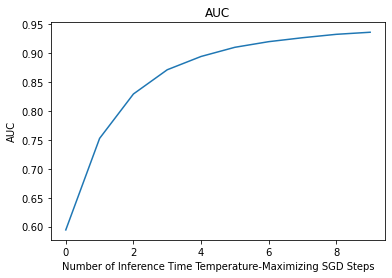

In [640]:
plt.plot(auc_ts)
plt.title("AUC")
plt.ylabel("AUC")
plt.xlabel("Number of Inference Time Temperature-Maximizing SGD Steps")

Text(0.5, 0, 'Number of Inference Time Temperature-Maximizing SGD Steps')

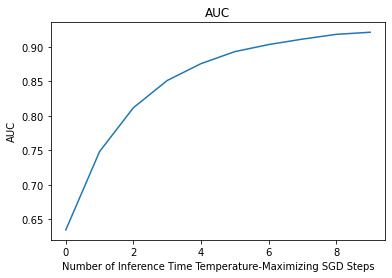

In [641]:
plt.plot(auc_cs)
plt.title("AUC")
plt.ylabel("AUC")
plt.xlabel("Number of Inference Time Temperature-Maximizing SGD Steps")

In [642]:
t = temperature_model.predict(encoding_X_test)
print("In Distribution Temperature: ", np.nanmean(t))

In Distribution Temperature:  0.8355733


In [643]:
t = temperature_model.predict(encoding_X_test_grad)
print("In Distribution Grad Temperature: ", np.nanmean(t))

In Distribution Grad Temperature:  2.774694


In [644]:
t = temperature_model.predict(np.array(vos_samples))
print("VO Temperature (we want this to be much higher than the in distribution temperature): ", np.nanmean(t))

VO Temperature (we want this to be much higher than the in distribution temperature):  3.007116


In [645]:
t = temperature_model.predict(encoding_X_ood)
print("OOD Temperature (we want this to be much higher than the in distribution temperature): ", np.nanmean(t))

OOD Temperature (we want this to be much higher than the in distribution temperature):  1.271956


In [646]:
t = temperature_model.predict(encoding_X_ood_grad)
print("OOD Grad Temperature (we want this to be much higher than the in distribution temperature): ", np.nanmean(t))

OOD Grad Temperature (we want this to be much higher than the in distribution temperature):  37.345325


In [647]:
vos_pred = ood_network.predict(np.array(vos_samples))
print("Temperature Deflated VO Confidence Average (we want this to be really low): ", np.mean(np.max(vos_pred, axis = 1)))

Temperature Deflated VO Confidence Average (we want this to be really low):  0.74612665


In [648]:
ood_pred = ood_network.predict(encoding_X_ood)
print("Temperature Deflated OOD Confidence Average (we want this to be really low): ", np.mean(np.max(ood_pred, axis = 1)))

Temperature Deflated OOD Confidence Average (we want this to be really low):  0.8152895


In [649]:
ood_grad_pred = ood_network.predict(encoding_X_ood_grad)
print("Temperature Deflated OOD Grad Confidence Average (we want this to be really low): ", np.nanmean(np.max(ood_grad_pred, axis = 1)))

Temperature Deflated OOD Grad Confidence Average (we want this to be really low):  0.5624003


In [650]:
id_pred = ood_network.predict(encoding_X_test)
print("Temperature Deflated In-Distribution Confidence Average: ", np.nanmean(np.max(id_pred, axis = 1)))

Temperature Deflated In-Distribution Confidence Average:  0.9000425


In [651]:
id_grad_pred = ood_network.predict(encoding_X_test_grad)
print("Temperature Deflated In-Distribution Grad Confidence Average: ", np.nanmean(np.max(id_grad_pred, axis = 1)))

Temperature Deflated In-Distribution Grad Confidence Average:  0.9107019


In [652]:
id_defined_indices = np.where([~np.isnan(v).any() for v in id_pred])[0]
ood_defined_indices = np.where([~np.isnan(v).any() for v in ood_pred])[0]
print("AUC: ",roc_auc_score(np.concatenate([np.ones((len(id_pred[id_defined_indices]))), np.zeros((len(ood_pred[ood_defined_indices])))]), np.concatenate([np.max(id_pred[id_defined_indices], axis = 1), np.max(ood_pred[ood_defined_indices], axis = 1)])))
id_defined_indices = np.where([~np.isnan(v).any() for v in id_grad_pred])[0]
ood_defined_indices = np.where([~np.isnan(v).any() for v in ood_grad_pred])[0]
print("Grad AUC: ",roc_auc_score(np.concatenate([np.ones((len(id_grad_pred[id_defined_indices]))), np.zeros((len(ood_grad_pred[ood_defined_indices])))]), np.concatenate([np.max(id_grad_pred[id_defined_indices], axis = 1), np.max(ood_grad_pred[ood_defined_indices], axis = 1)])))

AUC:  0.6617054444444445
Grad AUC:  0.9210166764357712


In [601]:
vo_pred = ood_network.predict(np.array(vos_samples))
print("Unaffected Model VO Confidence Average (this being high shows networks are overconfident OOD): ", np.mean(np.max(vo_pred, axis = 1)))

Unaffected Model VO Confidence Average (this being high shows networks are overconfident OOD):  0.74612665


In [602]:
ood_pred = ood_network.predict(encoding_X_test)
print("Unaffected Model OOD Confidence Average (this being high shows networks are overconfident OOD): ", np.mean(np.max(ood_pred, axis = 1)))

Unaffected Model OOD Confidence Average (this being high shows networks are overconfident OOD):  0.9000425


In [603]:
id_pred = network.predict(X_test)
print("Unaffected Model In-Distribution Confidence Average: ", np.mean(np.max(id_pred, axis = 1)))

Unaffected Model In-Distribution Confidence Average:  0.90531504


In [604]:
id_defined_indices = np.where([~np.isnan(v).any() for v in id_pred])[0]
ood_defined_indices = np.where([~np.isnan(v).any() for v in ood_pred])[0]
print("AUC: ",roc_auc_score(np.concatenate([np.ones((len(id_pred[id_defined_indices]))), np.zeros((len(ood_pred[ood_defined_indices])))]), np.concatenate([np.max(id_pred[id_defined_indices], axis = 1), np.max(ood_pred[ood_defined_indices], axis = 1)])))

AUC:  0.358755875


In [605]:
def get_ece(confidences, correctness):
    hists = []
    hists_hat = []
    amts = []
    num_bins = 1
    for i in range(num_bins):
        prop = i*1./num_bins
        inds = np.where((confidences >= prop) & (confidences <= prop+1./num_bins))[0]
        amts.append(len(inds))
        if len(inds) > 0:
            hists.append(len(np.where(correctness[inds] == 1)[0])*1./len(inds))
            hists_hat.append(np.mean(confidences[inds]))
        else:
            hists.append(prop)
            hists_hat.append(prop + 0.5/num_bins)
    return np.sum(np.abs(np.array(hists) - np.array(hists_hat)) * np.array(amts)) / np.sum(amts)

In [606]:
from sklearn.metrics import roc_auc_score, accuracy_score
pred = network.predict(X_test)

class_eces = []
for j in range(len(np.unique(y_train))):
    class_eces.append(get_ece(np.array(pred)[:, j], y_test == j))
np.mean(class_eces)

0.046210214495658875

In [607]:
from sklearn.metrics import roc_auc_score, accuracy_score
pred = encoding_network.predict(encoding_X_test)

class_eces = []
for j in range(len(np.unique(y_train))):
    class_eces.append(get_ece(np.array(pred)[:, j], y_test == j))
np.mean(class_eces)

0.046210214495658875

In [608]:
pred = ood_network.predict(encoding_X_test)
class_eces = []
for j in range(len(np.unique(y_train))):
    class_eces.append(get_ece(np.array(pred)[:, j], y_test == j))
np.mean(class_eces)

0.02632521092891693

In [627]:
model_predictions = encoding_network.predict(encoding_X_test)
ood_model_predictions = ood_network.predict(encoding_X_test)

In [628]:
num_intervals = 10

In [629]:
ood_scores_test = temperature_model.predict(encoding_X_test)[:, 0]

In [630]:
#z_scores = p_label_error / (variance_confidences + 1e-12)
from sklearn.metrics import average_precision_score
order = np.argsort(ood_scores_test)
ps = []
accs = []
base_eces = []
ood_model_eces = []
base_confidences = []
ood_model_confidences = []
model_acc = []
ood_model_acc = []

for i in range(0, len(y_test), int(len(y_test) / num_intervals)):
    class_eces = []
    for j in range(len(np.unique(y_train))):
        class_eces.append(get_ece(np.array(model_predictions)[order[:i + int(len(y_test) / num_intervals)], j], y_test[order[:i + int(len(y_test) / num_intervals)]] == j))
    base_eces.append(np.mean(class_eces))
    base_confidences.append(np.mean(model_predictions[order[i:i + int(len(y_test) / num_intervals)], 1]))
    model_acc.append(np.mean(np.argmax(model_predictions[order[i:i + int(len(y_test) / num_intervals)]], axis = 1) == 1))

    class_eces = []
    for j in range(len(np.unique(y_train))):
        class_eces.append(get_ece(np.array(ood_model_predictions)[order[:i + int(len(y_test) / num_intervals)], j], y_test[order[:i + int(len(y_test) / num_intervals)]] == j))
    ood_model_eces.append(np.mean(class_eces))
    ood_model_confidences.append(np.mean(ood_model_predictions[order[i:i + int(len(y_test) / num_intervals)], 1]))
    ood_model_acc.append(np.mean(np.argmax(ood_model_predictions[order[i:i + int(len(y_test) / num_intervals)]], axis = 1) == 1))

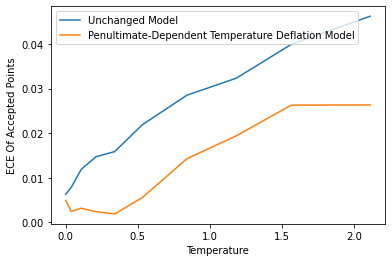

In [631]:
import matplotlib.pyplot as plt
plt.plot(ood_scores_test[order[np.arange(0, len(y_test), int(len(y_test) / num_intervals))]], base_eces, label = "Unchanged Model")
#plt.plot(np.arange(0, len(y_test), int(len(y_test) / num_intervals)) / len(y_test), base_eces, label = "Unchanged Model")
plt.plot(ood_scores_test[order[np.arange(0, len(y_test), int(len(y_test) / num_intervals))]], ood_model_eces, label = "Penultimate-Dependent Temperature Deflation Model")
#plt.plot(np.arange(0, len(y_test), int(len(y_test) / num_intervals)) / len(y_test), ood_model_eces, label = "Penultimate-Dependent Temperature Deflation Model")
plt.xlabel("Temperature")
plt.ylabel("ECE Of Accepted Points")
plt.legend()

The blue line increasing shows that when temperature is high, ECE is high -> we can detect when the baseline model is miscalibrated (when we're OOD) and we know it by a high temperature. On this, we deflate confidence.

The orange line being lower shows that when we deflate the temperature, it does increase calibration.